In [1]:

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader



In [2]:
# Data from: https://www.kaggle.com/datasets/theforcecoder/wind-power-forecasting?resource=download
df = pd.read_csv('./data/Turbine_Data.csv', index_col=0)
df.index = pd.DatetimeIndex(df.index)
df = df.fillna(-20)
df.head()

vars_of_interest = ['WindSpeed', 'ActivePower']
df = df[vars_of_interest]
train_df = df['2018-01-01':'2018-12-31']
test_df = df['2019-01-01':'2019-12-31']

means = train_df.mean()
stds = train_df.std()

train_df = (train_df - means) / stds
test_df = (test_df - means) / stds


In [3]:
len(train_df), len(test_df)

(52560, 52560)

<Axes: >

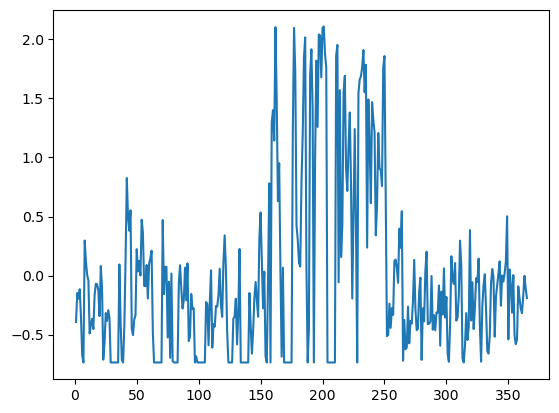

In [4]:
train_df['ActivePower'].groupby(train_df.index.dayofyear).mean().plot()

<Axes: >

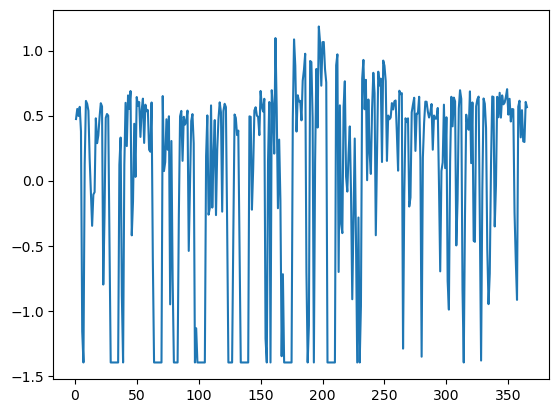

In [5]:
train_df['WindSpeed'].groupby(train_df.index.dayofyear).mean().plot()

<Axes: xlabel='WindSpeed', ylabel='ActivePower'>

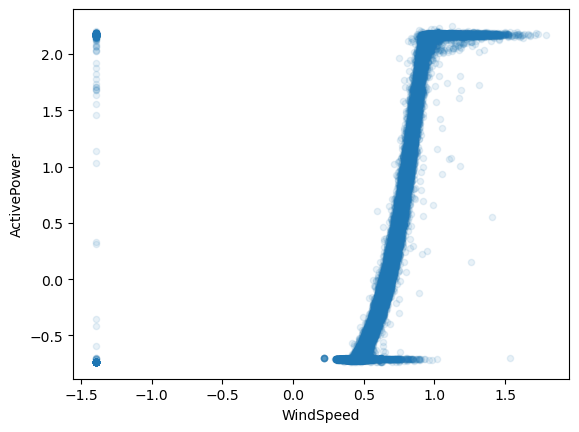

In [6]:
train_df.plot.scatter(x='WindSpeed', y='ActivePower', alpha=0.1)

In [7]:
# Create a PyTorch dataset
class WindDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size):
        self.df = df
        self.window_size = window_size

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        # Outputs have dims [window_size, num_features]
        window = self.df.iloc[idx:idx+self.window_size]
        wind_speed = window['WindSpeed'].values.reshape(-1, 1)
        active_power = window['ActivePower'].iloc[-1].reshape(-1, 1)
        x = torch.from_numpy(wind_speed).to(torch.float32)
        y = torch.from_numpy(active_power).to(torch.float32)
        return x, y

In [9]:
window_size = 24
dataset = WindDataset(train_df, window_size)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

In [10]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Input dims for x are [batch_size, window_size, num_features]
        # So flatten for the linear layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
    

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        o, h = self.rnn(x)
        return self.fc(o)[:, -1, :]
    

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        o, (h, c) = self.lstm(x)
        return self.fc(o)[:, -1, :]

In [11]:
mlp = SimpleMLP(24, 64, 1)
rnn = SimpleRNN(1, 64, 1)
lstm = SimpleLSTM(1, 64, 1)

opt_mlp = torch.optim.Adam(mlp.parameters(), lr=3e-3)
opt_rnn = torch.optim.Adam(rnn.parameters(), lr=3e-3)
opt_lstm = torch.optim.Adam(lstm.parameters(), lr=3e-3)

loss_fn = nn.L1Loss()

# Train the models
def train_model(model, opt, dataloader, epochs=10):
    losses = []
    model.train()
    for epoch in range(epochs):
        loss_avg = 0
        for i, (x, y) in enumerate(dataloader):
            y_pred = model(x)
            loss = loss_fn(y_pred.squeeze(), y.squeeze())
            opt.zero_grad()
            loss.backward()
            opt.step()
            loss_avg += loss.item()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        losses.append(loss_avg / i)
    return losses

In [12]:
mlp_losses = train_model(mlp, opt_mlp, dataloader)

Epoch 1, Loss: 0.29923462867736816
Epoch 2, Loss: 0.20237986743450165
Epoch 3, Loss: 0.18041503429412842
Epoch 4, Loss: 0.18545353412628174
Epoch 5, Loss: 0.17962802946567535
Epoch 6, Loss: 0.186346635222435
Epoch 7, Loss: 0.13821829855442047
Epoch 8, Loss: 0.14225271344184875
Epoch 9, Loss: 0.13744574785232544
Epoch 10, Loss: 0.1499149352312088


In [13]:
rnn_losses = train_model(rnn, opt_rnn, dataloader)

Epoch 1, Loss: 0.3960796892642975
Epoch 2, Loss: 0.18241703510284424
Epoch 3, Loss: 0.209422305226326
Epoch 4, Loss: 0.16629715263843536
Epoch 5, Loss: 0.18804560601711273
Epoch 6, Loss: 0.19125893712043762
Epoch 7, Loss: 0.1313406378030777
Epoch 8, Loss: 0.15707087516784668
Epoch 9, Loss: 0.11451711505651474
Epoch 10, Loss: 0.12124734371900558


In [14]:
lstm_losses = train_model(lstm, opt_lstm, dataloader)

Epoch 1, Loss: 0.33860594034194946
Epoch 2, Loss: 0.21643462777137756
Epoch 3, Loss: 0.19747501611709595
Epoch 4, Loss: 0.17603781819343567
Epoch 5, Loss: 0.17397475242614746
Epoch 6, Loss: 0.1641676425933838
Epoch 7, Loss: 0.13794901967048645
Epoch 8, Loss: 0.13079442083835602
Epoch 9, Loss: 0.11604021489620209
Epoch 10, Loss: 0.1315770447254181


Text(0, 0.5, 'Loss')

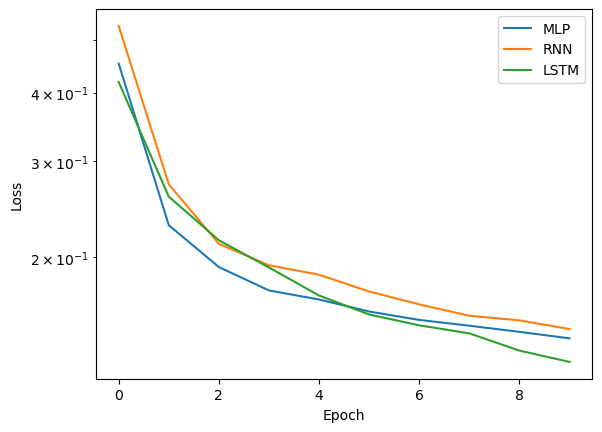

In [19]:
plt.plot(mlp_losses, label='MLP')
plt.plot(rnn_losses, label='RNN')
plt.plot(lstm_losses, label='LSTM')
plt.legend()
plt.semilogy()
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [21]:
# now we can test the models
test_dataset = WindDataset(test_df, window_size)
test_dataloader = DataLoader(test_dataset, batch_size=1)
test_data = test_df['ActivePower'].values[window_size:] * stds['ActivePower'] + means['ActivePower']

def test_model(model, dataloader):
    model.eval()
    preds = []
    for x, y in dataloader:
        y_pred = model(x)
        preds.append(y_pred.detach().numpy())
    return np.array(preds).squeeze()


In [22]:
mlp_preds = test_model(mlp, test_dataloader)
mlp_preds = mlp_preds * stds['ActivePower'] + means['ActivePower']

In [23]:
rnn_preds = test_model(rnn, test_dataloader)
rnn_preds = rnn_preds * stds['ActivePower'] + means['ActivePower']

In [24]:
lstm_preds = test_model(lstm, test_dataloader)
lstm_preds = lstm_preds * stds['ActivePower'] + means['ActivePower']

Text(0.5, 0, 'Time')

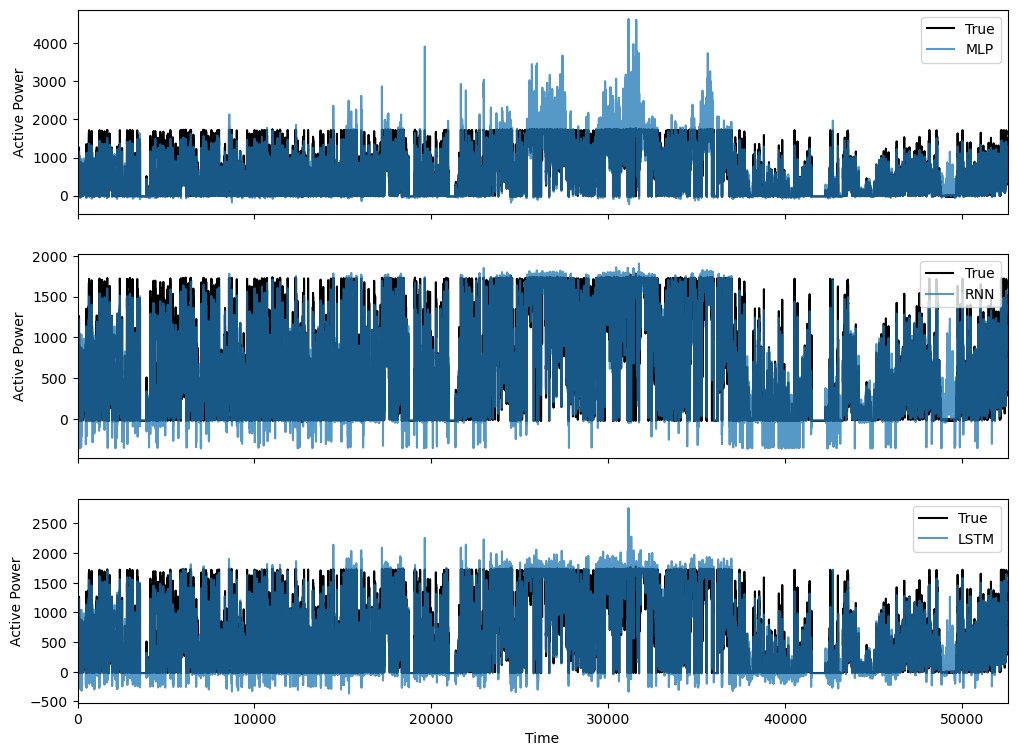

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
axes[0].plot(test_data, label='True', color='black')
axes[0].plot(mlp_preds, label='MLP', alpha=0.75)

axes[1].plot(test_data, label='True', color='black')
axes[1].plot(rnn_preds, label='RNN', alpha=0.75)

axes[2].plot(test_data, label='True', color='black')
axes[2].plot(lstm_preds, label='LSTM', alpha=0.75)

for ax in axes:
    ax.legend()
    ax.set_ylabel('Active Power')
    ax.set_xlim(0, 6 * 24 * 365)
axes[-1].set_xlabel('Time')

In [32]:
len(preds), len(test_data), len(rnn_preds)

(52536, 52536, 52536)

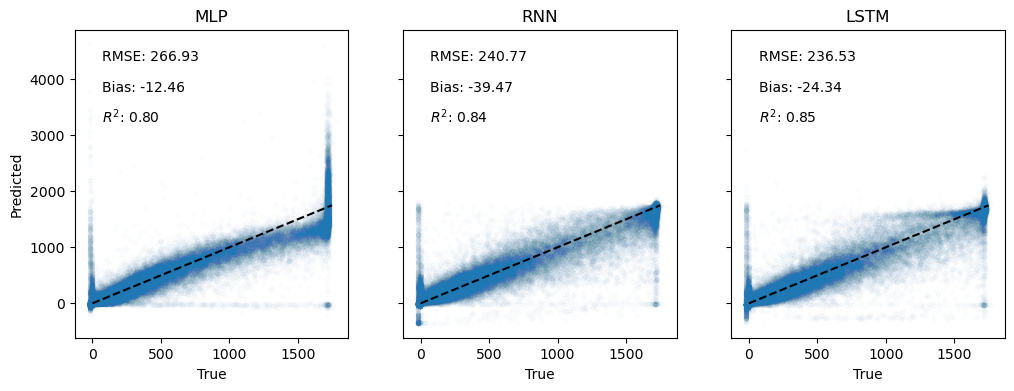

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
for ax, preds, name in zip(axes, [mlp_preds, rnn_preds, lstm_preds], ['MLP', 'RNN', 'LSTM']):
    ax.scatter(test_data, preds, alpha=0.01, marker='.')
    ax.plot([0, 1750], [0, 1750], color='black', linestyle='--')
    ax.set_title(name)
    ax.set_xlabel('True')

axes[0].set_ylabel('Predicted')

# Calculate the RMSE, Percent Bias, and R^2

def calculate_metrics(true, preds):
    true = np.copy(true)
    preds = np.copy(preds)
    preds = preds[true>1]
    true = true[true>1]
    rmse = np.sqrt(np.mean((true - preds)**2))
    r2 = 1 - np.sum((true - preds)**2) / np.sum((true - np.mean(true))**2)
    bias = np.mean((true - preds) / true) * 100
    return rmse, bias, r2

mlp_metrics = calculate_metrics(test_data, mlp_preds)
rnn_metrics = calculate_metrics(test_data, rnn_preds)
lstm_metrics = calculate_metrics(test_data, lstm_preds)

# Add metrics as text to the plot
for ax, metrics, name in zip(axes, [mlp_metrics, rnn_metrics, lstm_metrics], ['MLP', 'RNN', 'LSTM']):
    ax.text(0.1, 0.9, f'RMSE: {metrics[0]:.2f}', transform=ax.transAxes)
    ax.text(0.1, 0.8, f'Bias: {metrics[1]:.2f}', transform=ax.transAxes)
    ax.text(0.1, 0.7, f'$R^2$: {metrics[2]:.2f}', transform=ax.transAxes)